# Fitting difference of exponentials to voltage clamp data

In [1]:
import os
import sys
sys.path.append('../')
from matplotlib import pyplot as plt
import matplotlib
plt.style.use('seaborn-white')
import numpy as np
from Linearity import Neuron
import lmfit

In [2]:
analysisFile = '/media/sahil/NCBS_Shares_BGStim/patch_data/170530/c1_EI/plots/c1_EI.pkl'
plotDir = os.path.dirname(analysisFile)
neuron = Neuron.load(analysisFile)

## $g(t) = \bar{g}\frac{( e^\frac{\delta_{onset} - t }{\tau_{decay}} - e^\frac{\delta_{onset} - t }{\tau_{rise}})}{- \left(\frac{\tau_{rise}}{\tau_{decay}}\right)^{\frac{\tau_{decay}}{\tau_{decay} - \tau_{rise}}} + \left(\frac{\tau_{rise}}{\tau_{decay}}\right)^{\frac{\tau_{rise}}{\tau_{decay} - \tau_{rise}}}}$

In [3]:
def fitFunctionToPSP(time, vector, t_0=0, g_max=0):
    ''' Fits using lmfit '''

    def _doubleExponentialFunction(t, t_0, tOn, tOff, g_max):
        ''' Returns the shape of an EPSP as a double exponential function '''
        tPeak = t_0 + float(((tOff * tOn)/(tOff-tOn)) * np.log(tOff/tOn))
        A = 1./(np.exp(-(tPeak-t_0)/tOff) - np.exp(-(tPeak-t_0)/tOn))
        g = [ g_max * A * (np.exp(-(t_point-t_0)/tOff) - np.exp(-(t_point-t_0)/tOn)) if  t_point >= t_0 else 0. for t_point in t]
        return np.array(g)
 
    model = lmfit.Model(_doubleExponentialFunction)
    # Fixing values of variables from data
    # Onset time
    if not t_0:
        model.set_param_hint('t_0', value =max(time)/10., min=0., max = max(time))
    else:
        model.set_param_hint('t_0', value = t_0, vary=False)
    # g_max 
    if not g_max:
        model.set_param_hint('g_max', value = max(vector)/10., min = 0., max = max(vector))
    else:
        model.set_param_hint('g_max', value = g_max, vary=False)

    model.set_param_hint('tOn', value =max(time)/5.1 , min = 0., max = max(time))
    model.set_param_hint('t_ratio', value =10., min=1.05)
    model.set_param_hint('tOff', min = 0., expr='tOn*t_ratio')
    model.set_param_hint('t_peak', expr = 't_0 + ((tOff * tOn)/(tOff-tOn)) * log(tOff/tOn)')
    pars = model.make_params()

    result = model.fit(vector, pars, t=time)
    # print (result.fit_report())
    return result

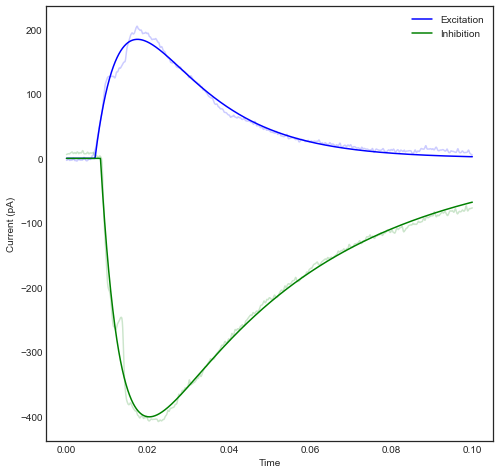

In [7]:
n = {key:value for key,value in neuron}
for numSq in set(n[1]).intersection(set(n[2])):
    for i in set(n[1][numSq].trial).intersection(set(n[2][numSq].trial)):
        if i == 3 and numSq == 7:
            exc = -1e9*n[1][numSq].trial[i].interestWindow
            inh = 1e9*n[2][numSq].trial[i].interestWindow
            time = np.arange(len(n[1][numSq].trial[i].interestWindow))*n[1][numSq].trial[i].samplingTime
            exc_fit = fitFunctionToPSP(time, exc)
            inh_fit = fitFunctionToPSP(time, inh)

            f,ax = plt.subplots() 
            ax.plot(time, exc, alpha=0.2, c='b')
            ax.set_xlabel("Time")
            ax.set_ylabel("Current (pA)")
            ax.plot(time, exc_fit.best_fit, '-', label="Excitation", c='b')

            ax.plot(time, -inh, alpha=0.2, c='g')
            ax.plot(time, -inh_fit.best_fit, '-', label="Inhibition", c='g')
            plt.legend()
            f.set_figwidth(8)
            f.set_figheight(8)
            plt.show()